<a href="https://colab.research.google.com/github/tony-wade/Qiskit/blob/main/How%20to%20run%20Qiskit%20circuit/Lec0_How_to_run_Qiskit_circuit_(ver_1_2_0_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author Information
This code is provided by **Wade Wu**.

For license information, please visit my [GitHub repository](https://github.com/tony-wade/Qiskit). Contributions and feedback are always welcome!


In [ ]:
!pip install qiskit qiskit-aer
!pip install qiskit-ibm-runtime
!pip install pylatexenc  # 圖像用

## qiskit.primitives: 模擬 quantum circuit 理論輸出

Estimator output info: https://github.com/Qiskit/RFCs/blob/master/0015-estimator-interface.md#arrays-and-broadcasting-

In [ ]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp, Pauli
import time
import numpy as np

num = 12
reps = 3

# create two parameterized circuits
pqc = RealAmplitudes(num_qubits=num, reps=2)
pqc2 = RealAmplitudes(num_qubits=num, reps=reps)

theta1 =  [i for i in range(num * 3)]
theta2 = [i for i in range(num * (reps + 1))]


sampler = Sampler()
estimator = Estimator()


print('Estimator')

# estimator至少須提供一observable
z_string = 'Z' * num
all_z_observable = [SparsePauliOp(Pauli(z_string))]

start_time1 = time.time()
job = estimator.run([(pqc, all_z_observable, theta1), (pqc2, all_z_observable, theta2)]) # .run([pub1,pub2,...])
esti_result1 = job.result()[0]    # 第一組

print(esti_result1.data.evs)  # 即期望值輸出,另一者為標準差,詳見上方連結
end_time1 = time.time()
print(f'duration: {end_time1-start_time1}','\n')


print('Sampler')

# sampler才能有measure
pqc.measure_all()
pqc2.measure_all()

# 設定所求
bitstring = '111111111111'

start_time2 = time.time()
job = sampler.run([(pqc, theta1), (pqc2, theta2)], shots=1000)
samp_result1 = job.result()[0]
count = samp_result1.data.meas.get_counts().get(bitstring, 0)

print(f'count: {count}')
print(samp_result1.data.meas.get_counts())
print(samp_result1.data.meas.expectation_values(all_z_observable))  # 不同於當下取樣
end_time2 = time.time()
print(f'duration: {end_time2-start_time2}')

Estimator
[-0.00596183]
duration: 0.07545089721679688 

Sampler
count: 0
{'101011000001': 1, '100001111000': 1, '100010001001': 2, '111101110111': 1, '101000000100': 3, '001100110010': 4, '111100010001': 2, '001101100000': 3, '111010010001': 2, '101001101001': 1, '001111011000': 5, '111000011000': 1, '111011111000': 1, '000101111010': 1, '110010000000': 3, '000000001010': 1, '000100001111': 1, '000100110100': 1, '100101001100': 1, '001101111000': 4, '100100011100': 1, '100011011010': 2, '111101001001': 2, '101000111010': 2, '111101011001': 3, '111010001000': 2, '001100111101': 2, '000001000010': 3, '011101011001': 1, '111101111101': 3, '001101110100': 7, '000010111000': 1, '001001011000': 4, '110101111100': 3, '000111101001': 2, '110100001011': 1, '110010011111': 1, '100111111001': 1, '110111000000': 5, '111100111010': 3, '101011010001': 2, '111101110101': 3, '101001111001': 1, '011101111101': 1, '000110110011': 1, '111110001110': 1, '000101111110': 1, '100100001100': 2, '000001011000'

## qiskit_ibm_runtime: 使用/模擬QPU

 **Qiskit Runtime execution modes**


*   Job:  單一程序/request
*   Session: 連貫Jobs, 免除多次隊列, 能用量子/傳統複合電路，**適用於訓練參數化電路**, open-plan使用會被降轉為多個Job...
*    Batch: 平行Jobs, 免除多次隊列, 但job之間的先後順序沒有被保證



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.visualization import plot_histogram
import random

# Load account, set to default
QiskitRuntimeService.save_account(channel="ibm_quantum", token="285d4c19f2991a9761a2d38a63625cb83d5bba0ab72b9f5d8dc76e18e8ecd2845a96fcc3b6987a0d2ae4b509d8cdd6a575965395896a5c12c449068f185dc765",
                                  overwrite=True, set_as_default=True)

###  將circuit送到QPU實際運算

**SO FAST**

In [ ]:
num = 32
reps = 3

# Circuit and parameters
pqc = RealAmplitudes(num_qubits=num, reps=reps)
theta = [random.randint(1, 10) for _ in range(num * (reps + 1))]

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=32)   # Choose the least busy one


# Create observable
z_string = 'Z' * num
coefficients = [1.0]  # Coefficient for the full-Z operator
all_z_observable = SparsePauliOp.from_list([(z_string, coefficients[0])])

# transpile to fit in ibm hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
isa_pqc = pm.run(pqc)
observable = all_z_observable.apply_layout(isa_pqc.layout)

estimator = Estimator(mode=backend)
job = estimator.run([(isa_pqc, observable, theta)])

# 花了9min,但實際只需15s(by backend)
pub_result = job.result()[0]
print(f"Expectation values: {pub_result.data.evs}")

Expectation values: -0.00439453125


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=32)

# Sampler need measurement
pqc.measure_all()

# transpile to fit in ibm hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
isa_pqc = pm.run(pqc)

sampler = Sampler(mode=backend)
job2 = sampler.run([(isa_pqc, theta)], shots=100)

# 等了24min,實際用了4秒(100shots)
print(job2.result()[0].data.meas.get_counts())

{'00011001000001001011010011011010': 1, '11011011101000101111111111100111': 1, '11111010101010000100010111101011': 1, '11111111101111000001110110111011': 1, '11101001100000000001011100100101': 1, '00111011011010001111101111100100': 1, '01010001110010010100001010001110': 1, '11010001101000100001010000001011': 1, '00000011011010001111001111100010': 1, '01001110110100000000000100110010': 1, '11010111010001111111111000000011': 1, '10000111010100111011110100101100': 1, '11110110000010110001101111100101': 1, '01101010100110000010101111101101': 1, '01110100111010111000110101110111': 1, '11000000000100001011101101110011': 1, '11100110111010001000000001010010': 1, '10011011011110011000110001011010': 1, '11010011000010110000110001011001': 1, '11010011000111011110111110111001': 1, '01111000000001011101100101101010': 1, '10011111101100011011010101100010': 1, '10001111111101010110000110011110': 1, '10000011000010011110100000110010': 1, '10000001100110110010010111101000': 1, '11101000010010011100100

In [ ]:
# Create observable
z_string = 'Z' * num
coefficients = [1.0]  # Coefficient for the full-Z operator
all_z_observable = SparsePauliOp.from_list([(z_string, coefficients[0])])

print(job2.result()[0].data.meas.expectation_values(all_z_observable))  # sampler期望值

0.08


### 在個人電腦模擬QPU真實環境

Compare to StatevectorEstimator, AerSimulator do a better job on large circuit.


詳細情況:

Set 32 qubits, RealAmplitudes circuit with scipy (simillar to the example below)


*   AerSimulator: roughly 3.5 min and  70GB RAM for 1 iter
*   StatevectorEstimator:  **Failed to execute**





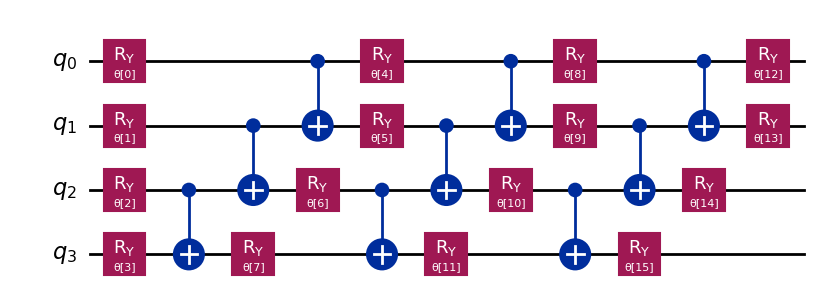

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2   # 這系列的似乎都跑很慢
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime  import EstimatorV2 as Estimator

backend = FakeBogotaV2()  # 5 qubits only
backend2 = AerSimulator()

num = 4
reps = 3

# Circuit and parameters
pqc = RealAmplitudes(num_qubits=num, reps=reps)
theta = [random.randint(1, 10) for _ in range(num * (reps + 1))]

hamiltonian = SparsePauliOp.from_list([("Z" * num, 1)])

# Transpile to a circuit that can be directly executed by the backend
pm = generate_preset_pass_manager(backend=backend2, optimization_level=0)
isa_pqc = pm.run(pqc)
observable = hamiltonian.apply_layout(isa_pqc.layout)
isa_pqc.draw('mpl', idle_wires=False, fold=-1)

In [ ]:
from scipy.optimize import minimize

def cost_func(params, ansatz, hamiltonian, estimator):
    return estimator.run([(ansatz, hamiltonian, theta)]).result()[0].data.evs

with Session(backend=backend2) as session:
    estimator = Estimator(mode=session)
    res = minimize(cost_func, theta, args=(isa_pqc, observable, estimator), method="COBYLA", options={"maxiter": 2})
    print(res) # success是指收斂成功與否


session.close()

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.005859375
       x: [ 3.000e+00  3.000e+00 ...  3.000e+00  6.000e+00]
    nfev: 2
   maxcv: 0.0
